In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, declare them in the YAML spec and leave this
# as None
##NOTE necessary to ignore warnings for usable report.
import warnings
from collections import defaultdict
from pathlib import Path
from pprint import pprint

from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import BayesianRidge, Lasso, ARDRegression, LassoCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")
from hydro_timeseries.plotting import plot_corr_matrix, tsplot, trend_eval_plot, get_windows, plot_fea_importance
from hydro_timeseries.util import load_timeseries_csv, add_mean_vars, OLS_analysis, smape, \
    get_sample_weights
from sktime.forecasting.model_selection import ExpandingWindowSplitter
import numpy as np

import pandas as pd

from hydro_timeseries.variables import Variables
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
upstream = None

# This is a placeholder, leave it as None
product = None

In [4]:
# Parameters
random_seed = 1
valid_from = "2021-11-01"
daily_discount_rate = 0.005
plots_path = "/home/m/repo/hydro-power-prediction/plots"
upstream = {"run-tests": {"nb": "/home/m/repo/hydro-power-prediction/reports/run_tests.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/data_raw_tested.csv"}, "feature-manual": {"nb": "/home/m/repo/hydro-power-prediction/reports/feature_manual.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/feature_manual.csv"}}
product = {"nb": "/home/m/repo/hydro-power-prediction/reports/exploratory_meteo.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/arima_manual_features.csv"}


In [5]:
'''
Load data for 15 minute and daily.
'''
data = load_timeseries_csv(upstream['run-tests']['data'])
data_daily = data.resample('D').mean()
data_hourly = data.resample('h').mean()

data = add_mean_vars(data)
data_daily = add_mean_vars(data_daily)
data_hourly = add_mean_vars(data_hourly)
plots_path = Path(plots_path)

In [6]:
#Meteo is the most recent. Thats why 15 minutes
train_until = pd.to_datetime(valid_from) - timedelta(minutes=15)
train = data[:train_until]
val = data[valid_from:]

# NOTE drop NaN Values for the last two days
val = val.dropna(axis = 0)

train_daily = data_daily[:train_until]
train_hourly = data_hourly[:train_until]

<Figure size 432x288 with 0 Axes>

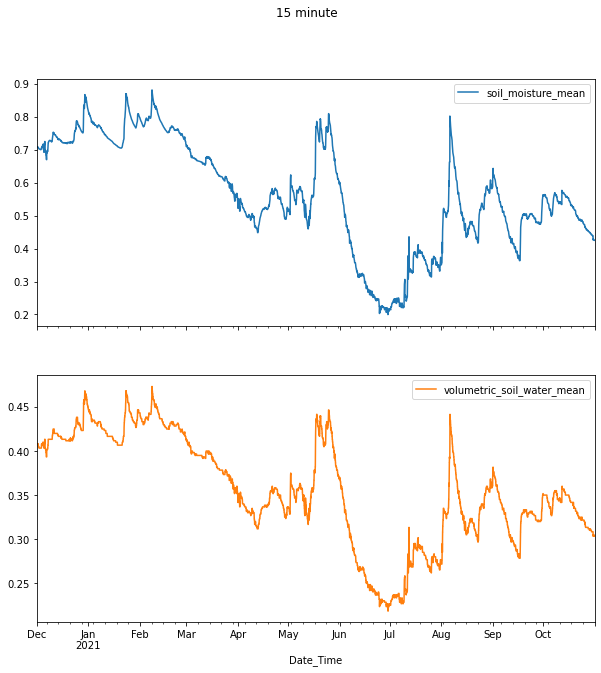

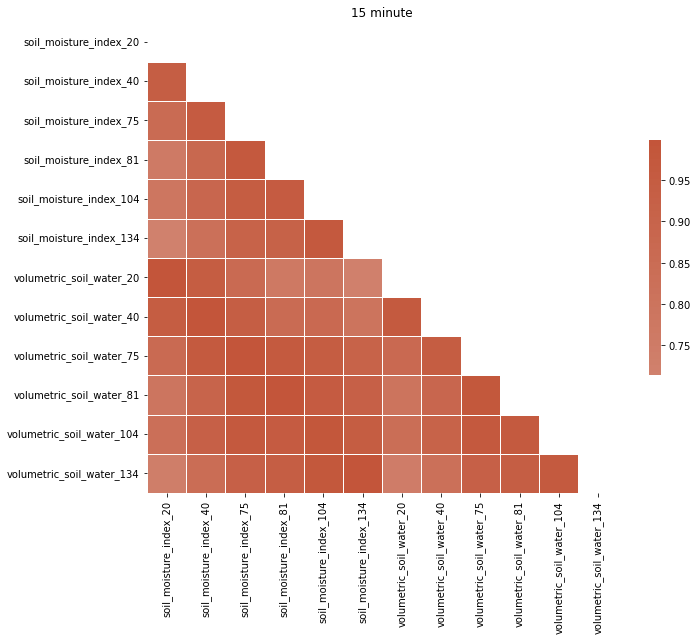

                           soil_moisture_index_20  soil_moisture_index_40  \
soil_moisture_index_20                   1.000000                0.937020   
soil_moisture_index_40                   0.937020                1.000000   
soil_moisture_index_75                   0.854048                0.953756   
soil_moisture_index_81                   0.757931                0.874679   
soil_moisture_index_104                  0.784868                0.887626   
soil_moisture_index_134                  0.713735                0.826520   
volumetric_soil_water_20                 0.996832                0.950074   
volumetric_soil_water_40                 0.947168                0.997229   
volumetric_soil_water_75                 0.860941                0.959787   
volumetric_soil_water_81                 0.790370                0.902317   
volumetric_soil_water_104                0.830496                0.924034   
volumetric_soil_water_134                0.736632                0.848161   

In [7]:
'''
DROPPED VARS

soil_moisture and volumetric_soil_water - almost perfect correlation even on the 15 min steps
- For simplicity and speed of computation, only soil_moisture is used further. 
'''
plt.figure()
train[['soil_moisture_mean', 'volumetric_soil_water_mean']].plot(subplots=True, sharex=True, figsize=(10,10), title='15 minute')
plt.show()

corr_mat = train[Variables.soil_moisture_water].dropna().corr()
plot_corr_matrix(corr_mat, '15 minute')

print(corr_mat)

In [8]:
'''
Var Selectors
'''
meteo_sel = ['Value'] + Variables.meteo_i
meteo_mean_sel = ['Value'] + Variables.meteo_means_i

<Figure size 432x288 with 0 Axes>

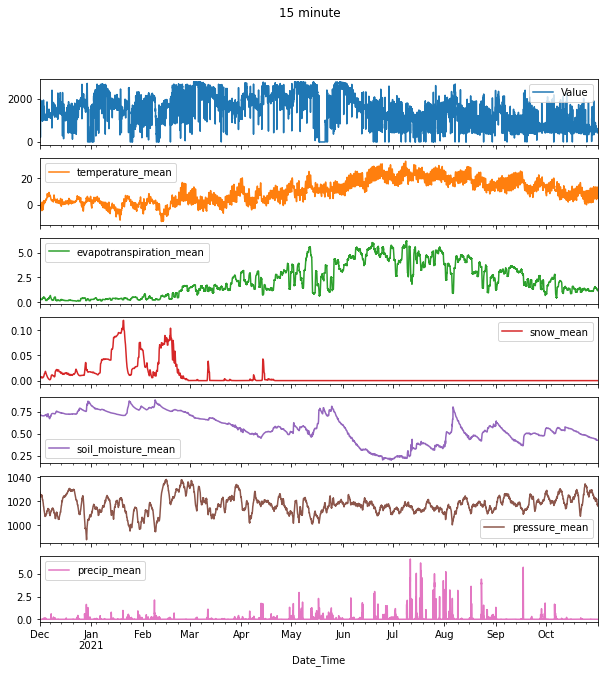

In [9]:
'''
MULTIPLOTS

Multiplots - eyecheck for patterns between meteo and target
positive correlations:
STRONG: rising temperature -> rising transpiration
WEAK: higher snow_mean -> higher soil_moisture

negative correlations:
medium: drop in pressure -> high precip_mean (storm)

TARGET:
soil moisture -> target
'''
plt.figure()
train[meteo_mean_sel].plot(subplots=True, sharex=True, figsize=(10,10), title='15 minute')
plt.savefig(plots_path / 'meteo_eye_plot.png')
plt.show()

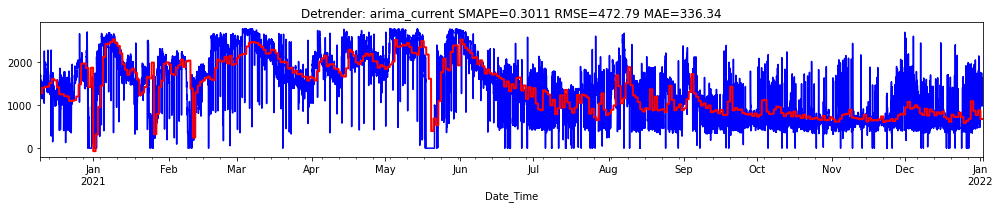

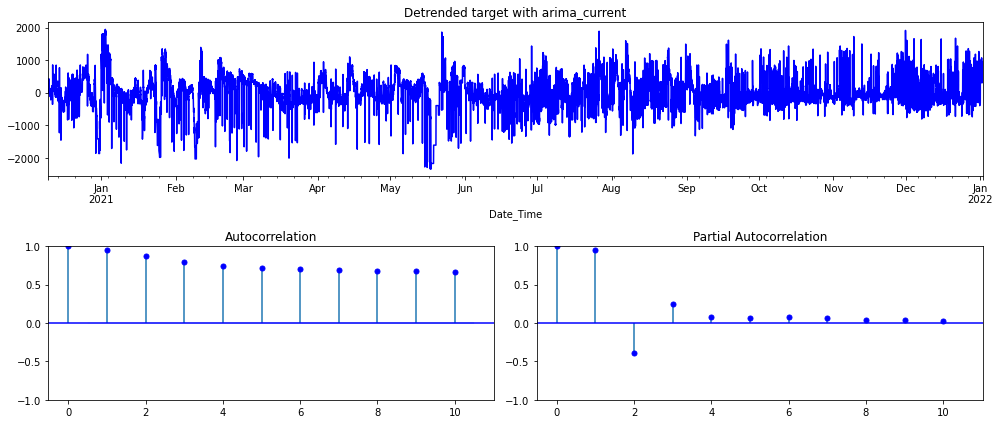

In [10]:
'''
DETRENDED TARGET
- further, the features are analyzed in regards to detrended target with a specified detrender
detrenders = ['arima_current', 'ets', 'exp', 'stl']
- add lagged detrended target variable (lag 2)
'''

detrender = 'arima_current'
features = load_timeseries_csv(upstream['feature-manual']['data'])

trend_eval_plot(features['Value'], features[detrender], compare=True, label=f"Detrender: {detrender}",
                filepath=plots_path / "chosen_detr.png")

value_detr = (features['Value'] - features[detrender]).dropna()

tsplot(value_detr, label =f'Detrended target with {detrender}', filepath=plots_path / "detrended_target.png")



In [11]:
'''
Add detrended target
- include daily mean of the detrended target lagged by two days. 
'''
features_new = features.assign(value_detr = value_detr)
features_new['value_detr_daily_lag2'] = features_new['value_detr'].resample('D').mean().shift(2)
features_new['value_detr_daily_lag2'] = features_new['value_detr_daily_lag2'].ffill()

target = 'Value'
target_new = 'value_detr'
target_new_lag2 = 'value_detr_daily_lag2'

In [12]:
'''
NOTE careful about dropna
'''
features_new[['value_detr', 'value_detr_daily_lag2']].tail(784).resample('D').mean()

,value_detr,value_detr_daily_lag2
Date_Time,,
2021-12-26,325.970594,-165.907532
2021-12-27,286.043435,40.770570
2021-12-28,-284.343002,501.814344
2021-12-29,38.725483,286.043435
2021-12-30,-87.072683,-284.343002
2021-12-31,63.540557,38.725483
2022-01-01,688.409267,-87.072683
2022-01-02,NaN,63.540557
2022-01-03,NaN,688.409267


In [13]:
'''
Drop zero Values?
'''
# features_new = features_new[features_new['Value'] != 0]

features_train = features_new[:train_until]
features_test = features_new[valid_from:].dropna()

In [14]:
corr_sel = ['value_detr'] + Variables.meteo
corr_sel_means = ['value_detr'] + Variables.meteo_means_i

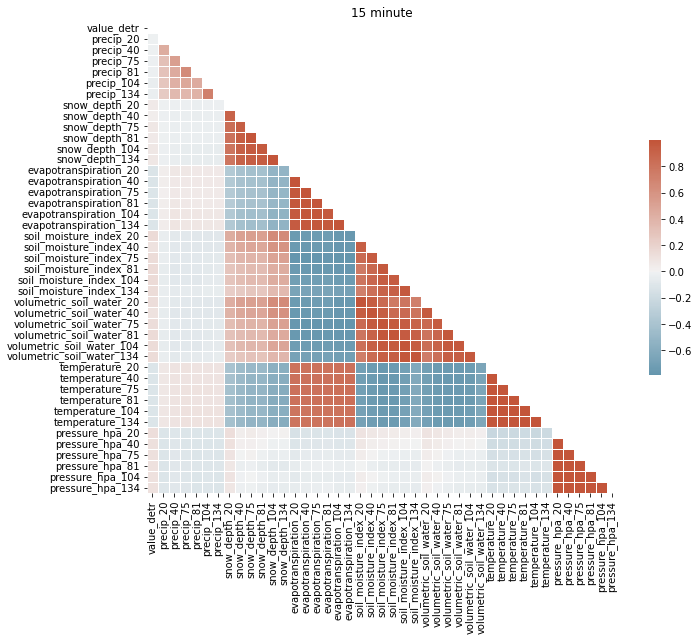

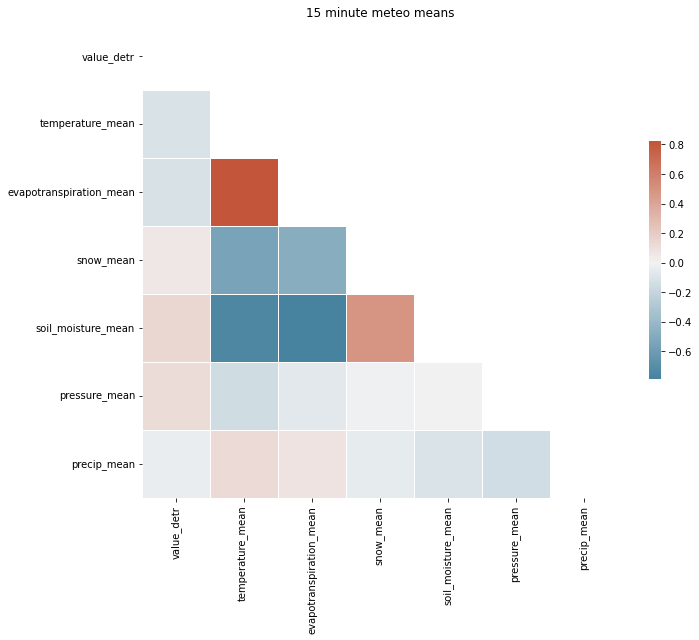

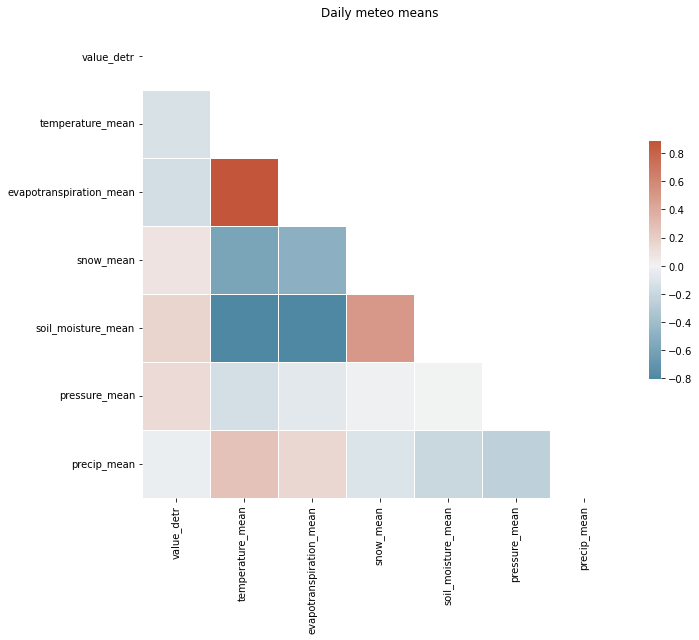

In [15]:
'''
Train Correlation matrices for 15 minute and daily
- most significant soil_moisture, temperature
- interestingly precip_mean is around 0 correlation with residuals after detrending
Meteo stations strongly correlate - for simplicity means are used further
- perhaps different precip_i measurements seem different enough to be used later.
'''
corr_mat = features_train[corr_sel].dropna().corr()
plot_corr_matrix(corr_mat, '15 minute')

corr_mat_means = features_train[corr_sel_means].dropna().corr()
plot_corr_matrix(corr_mat_means, '15 minute meteo means')

corr_mat_daily_means = features_train[corr_sel_means].dropna().resample('D').mean().corr()
plot_corr_matrix(corr_mat_daily_means, 'Daily meteo means')

In [16]:
'''
top10 meteo vars by correlation
'''
print("Top 10 meteo")
print(np.abs(corr_mat['value_detr'][Variables.meteo_i]).sort_values(ascending=False).head(10))


# print("Meteo means")
# print(np.abs(corr_mat_means['value_detr'][Variables.meteo_means_i]).sort_values(ascending=False))

Top 10 meteo
soil_moisture_index_81     0.141967
soil_moisture_index_104    0.140683
soil_moisture_index_20     0.139955
soil_moisture_index_134    0.135284
soil_moisture_index_75     0.134490
evapotranspiration_20      0.124984
evapotranspiration_40      0.124436
evapotranspiration_81      0.124313
pressure_hpa_20            0.119161
evapotranspiration_75      0.119053
Name: value_detr, dtype: float64


In [17]:
'''
OLS analysis of meteo + sin/cos transformed datetime cyclicals
- R squared around 0.039 :D -> need for some advanced features
- Cyclicals are chosen to be week_of_year and month only to not lead into memorization during training
- precip_mean with p-val = 0.1216, perhaps most of its power has been explained away by detrending.
NOTES:
Multicollinearity refers to independent variables that are correlated. 
This problem can obscure the statistical significance of model terms, 
produce imprecise coefficients, and make it more difficult to choose the correct model.

Multicollinearity - some sort of regularization - ridge...

'''
OLS_analysis(target_new, Variables.meteo_means_i + Variables.cyclical + [target_new_lag2], features_train)

                    Results: Ordinary least squares
Model:                OLS               Adj. R-squared:      0.039     
Dependent Variable:   0.0000            AIC:                 87034.5648
Date:                 2022-08-24 15:57  BIC:                 87134.7059
No. Observations:     31104             Log-Likelihood:      -43505.   
Df Model:             11                F-statistic:         116.7     
Df Residuals:         31092             Prob (F-statistic):  4.05e-263 
R-squared:            0.040             Scale:               0.96071   
-----------------------------------------------------------------------
                         Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------------
const                    0.0000   0.0056  0.0000 1.0000 -0.0109  0.0109
temperature_mean         0.0674   0.0128  5.2602 0.0000  0.0423  0.0925
evapotranspiration_mean -0.1166   0.0137 -8.5238 0.0000 -0.1434 -0.0898
snow_mean   

In [18]:
'''sin better than cos for cyclicals'''
OLS_analysis(target_new, Variables.cyclical, features_train)

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.014     
Dependent Variable: 0.0000           AIC:                88372.1996
Date:               2022-08-24 15:57 BIC:                88413.9558
No. Observations:   31296            Log-Likelihood:     -44181.   
Df Model:           4                F-statistic:        113.8     
Df Residuals:       31291            Prob (F-statistic): 1.65e-96  
R-squared:          0.014            Scale:              0.98582   
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               -0.0000   0.0056 -0.0000 1.0000 -0.0110  0.0110
sin_month            0.3420   0.0353  9.6860 0.0000  0.2728  0.4111
cos_month            0.0787   0.0380  2.0721 0.0383  0.0043  0.1530
sin_week_of_year    -0.3209   0.0362 -8.8653 0.0000 -0.3918 -0.249

In [19]:
'''
OLS analysis of lagged STL trend variables 
'''
OLS_analysis(target_new, Variables.stl, features_train)

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.009     
Dependent Variable: 0.0000           AIC:                88547.8603
Date:               2022-08-24 15:57 BIC:                88572.9141
No. Observations:   31296            Log-Likelihood:     -44271.   
Df Model:           2                F-statistic:        136.8     
Df Residuals:       31293            Prob (F-statistic): 7.37e-60  
R-squared:          0.009            Scale:              0.99143   
-------------------------------------------------------------------
                    Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------
const               0.0000   0.0056   0.0000 1.0000 -0.0110  0.0110
stl_trend_lag2     -0.0426   0.0058  -7.2936 0.0000 -0.0540 -0.0311
stl_seasonal_lag2  -0.0947   0.0058 -16.2388 0.0000 -0.1062 -0.0833
------------------------------------------------------------------

In [20]:
OLS_analysis(target_new, Variables.meteo_means_i + Variables.cyclical + Variables.stl, features_train)

                    Results: Ordinary least squares
Model:                 OLS               Adj. R-squared:      0.071     
Dependent Variable:    0.0000            AIC:                 86520.9511
Date:                  2022-08-24 15:57  BIC:                 86629.5173
No. Observations:      31296             Log-Likelihood:      -43247.   
Df Model:              12                F-statistic:         200.5     
Df Residuals:          31283             Prob (F-statistic):  0.00      
R-squared:             0.071             Scale:               0.92896   
------------------------------------------------------------------------
                         Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------------
const                   -0.0000   0.0054  -0.0000 1.0000 -0.0107  0.0107
temperature_mean         0.0354   0.0126   2.8031 0.0051  0.0106  0.0601
evapotranspiration_mean -0.0451   0.0138  -3.2665 0.0011 -0.0722 -0.0180

In [21]:
feature_cols_pred = Variables.meteo_means_i +\
               Variables.cyclical_sin + \
               Variables.stl + \
               Variables.meteo_i + \
               Variables.meteo_ewms_minute + \
               Variables.meteo_ewms_hourly + \
               Variables.lagged + \
               [target_new_lag2]

target_sc = StandardScaler()
feature_sc = StandardScaler()

fs_df_train = features_train[[target_new] + feature_cols_pred].dropna()
fs_df_test = features_test[[target_new] + feature_cols_pred].dropna()

X_train = pd.DataFrame(feature_sc.fit_transform(fs_df_train[feature_cols_pred]), index=fs_df_train.index, columns=fs_df_train[feature_cols_pred].columns)
y_train = pd.DataFrame(target_sc.fit_transform(fs_df_train[[target_new]]), index=fs_df_train.index)

X_test = pd.DataFrame(feature_sc.fit_transform(fs_df_test[feature_cols_pred]), index=fs_df_test.index, columns=fs_df_test[feature_cols_pred].columns)
y_test = pd.DataFrame(target_sc.fit_transform(fs_df_test[[target_new]]), index=fs_df_test.index)

'''
Var selector 
- extree
- lgbm
- lasso - worked best
'''

# var_selector_model = ExtraTreesRegressor(n_estimators=50, random_state=random_seed)
# var_selector_model = LGBMRegressor(n_estimators=50, random_state=random_seed)
var_selector_model = Lasso(alpha=0.1)


weights = get_sample_weights(X_train, daily_discount_rate)
var_selector_model = var_selector_model.fit(X_train, y_train)
var_selector = SelectFromModel(var_selector_model, prefit=True)
X_train_new = var_selector.transform(X_train)


# plot_fea_importance(var_selector_model, X_train)

selected_vars_ = X_train.columns[var_selector.get_support()].to_list()

# selected_vars = selected_vars_

selected_vars = [
 'stl_seasonal_lag2',
 'soil_moisture_index_75',
 'soil_moisture_index_104',
 'soil_moisture_index_134',
 'daily_mean_precip_104_lag1',
 'daily_mean_precip_104_lag2',
 'daily_mean_Value_lag2',
]

print("Selected vars")
pprint(selected_vars)

Selected vars
['stl_seasonal_lag2',
 'soil_moisture_index_75',
 'soil_moisture_index_104',
 'soil_moisture_index_134',
 'daily_mean_precip_104_lag1',
 'daily_mean_precip_104_lag2',
 'daily_mean_Value_lag2']


In [22]:
# plot_fea_importance(var_selector_model, X_train[selected_vars_])

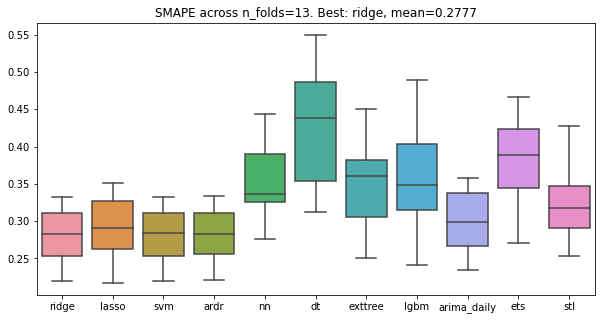

ridge          0.277704
lasso          0.286273
svm            0.277848
ardr           0.279633
nn             0.351203
dt             0.433503
exttree        0.349330
lgbm           0.361200
arima_daily    0.300241
ets            0.379974
stl            0.324695
dtype: float64


In [23]:
'''
Rolling weekly cross val - monthly test set
- used as model selection
- walk forward model checking - too expensive for more complex models

#TODO GaussianProcessRegressor using gpytorch, scikit GP SIGKILLs when dataset > 10000
'''

monthly = 96*30
weekly = 96*7
fh_monthly = list(range(1, monthly))

X_all = features_new[[target_new] + feature_cols_pred].dropna()
cv = ExpandingWindowSplitter(initial_window=int(len(X_all) * 0.7), step_length=weekly, fh=fh_monthly)
train_windows, test_windows = get_windows(X_all, cv)


models = {
    'ridge': Pipeline([('regressor', BayesianRidge())]),
    'lasso': Pipeline([
        # ('poly', PolynomialFeatures(interaction_only=False)),
        ('regressor', LassoCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1]))
    ]),

    'svm': Pipeline([
        ('regressor', LinearSVR(C=2.0, loss = 'squared_epsilon_insensitive'))
    ]),
    'ardr': Pipeline([
        ('regressor', ARDRegression())
    ]),
    'nn': Pipeline([
        ('pca', PCA(n_components=4)),
        ('regressor', MLPRegressor(hidden_layer_sizes=(32), alpha=5.0, early_stopping=True, learning_rate='adaptive'))]),

    # # 'gp': Pipeline([('selector', SelectFromModel(Lasso(alpha=0.05))),
    # #                 ('regressor', GaussianProcessRegressor())]),

    'dt': Pipeline([('regressor', DecisionTreeRegressor(max_depth = 15, random_state=random_seed))]),
    'exttree': Pipeline([('regressor', ExtraTreesRegressor(n_estimators=30, max_depth=15, random_state=random_seed))]),
    'lgbm': Pipeline([('regressor', LGBMRegressor(n_estimators=30, max_depth=15, random_state=random_seed))]),

}

smapes = defaultdict(list)

for fold_id, (train_ids, test_ids) in enumerate(cv.split(X_all)):
    X_train = X_all.iloc[train_ids][feature_cols_pred]
    X_test = X_all.iloc[test_ids][feature_cols_pred]
    y_train = X_all.iloc[train_ids][target_new]
    y_test = X_all.iloc[test_ids][target_new]

    X_train_scaled = pd.DataFrame(feature_sc.fit_transform(X_train), index=X_train.index,
                           columns=X_train.columns)

    y_train_scaled = pd.DataFrame(target_sc.fit_transform(y_train.values.reshape(-1,1)),
                                  index=y_train.index)

    X_test_scaled = pd.DataFrame(feature_sc.fit_transform(X_test), index=X_test.index,
                                  columns=X_test.columns)

    y_test_scaled = pd.DataFrame(target_sc.fit_transform(y_test.values.reshape(-1,1)),
                                  index=y_test.index)


    sample_weights = get_sample_weights(X_train, daily_discount_rate)
    for key in models:
        model = models[key]

        if 'selector' not in model.named_steps.keys():
            '''
            If feature selection is not part of pipeline, use pre selected list.
            '''
            X_train_scaled = X_train_scaled[selected_vars]
            X_test_scaled = X_test_scaled[selected_vars]


        if key == 'nn' or key == 'ardr' or key == 'gp':
            model.fit(X_train_scaled, y_train_scaled)
        else:
            model.fit(X_train_scaled, y_train_scaled, regressor__sample_weight=sample_weights)

        y_pred = target_sc.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))
        y_pred = pd.DataFrame(y_pred, index=y_test_scaled.index, columns=[target_new])
        value_pred = features_new.loc[y_pred.index][detrender] + y_pred.loc[y_pred.index][target_new]
        value_true = features_new.loc[y_pred.index]['Value']
        smapes[key].append(smape(value_true, value_pred))

    # add detrenders arima, autoets, stl for comparison
    value_pred = features_new.loc[X_test.index]['arima_current']
    value_true = features_new.loc[X_test.index]['Value']
    smapes['arima_daily'].append(smape(value_true, value_pred))

    value_pred = features_new.loc[X_test.index]['ets']
    smapes['ets'].append(smape(value_true, value_pred))

    value_pred = features_new.loc[X_test.index]['stl']
    smapes['stl'].append(smape(value_true, value_pred))

smapes = pd.DataFrame().from_dict(smapes)
best_model_name = np.mean(smapes).idxmin()

plt.figure(figsize=(10,5))
sns.boxplot(data = smapes)
ax = plt.gca()
ax.set_title(f'SMAPE across n_folds={len(train_windows)}. Best: {best_model_name}, mean={np.mean(smapes[best_model_name]):.4f}')
plt.savefig(plots_path / 'cv_manual.png')
plt.show()

print(np.mean(smapes))

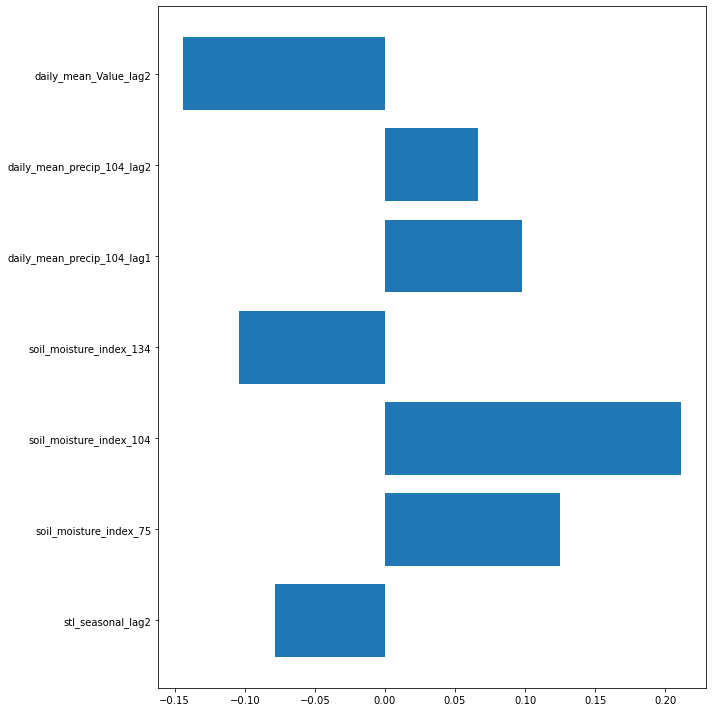

In [24]:
lm = models[best_model_name].named_steps['regressor']
importance = lm.coef_
plt.figure(figsize=(10,10))
plt.barh([x for x in selected_vars], importance)
plt.tight_layout()
plt.savefig(plots_path / 'weights_weekly.png')
plt.show()

smape_final = 0.29


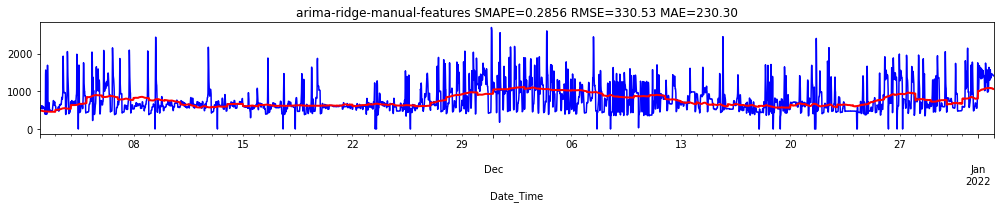

In [25]:
'''
Walk forward evaluation 
- only performed with the chosen model
- var selection is done in the previous step - not a good idea to do it every step. 
'''
step = 96
fh = np.arange(97, 193)
cv = ExpandingWindowSplitter(initial_window=len(X_all[:pd.to_datetime(valid_from) - timedelta(minutes=15)]), step_length=step, fh=fh)
train_windows, test_windows = get_windows(X_all, cv)

selected_vars = [
 'sin_month',
 'stl_seasonal_lag2',
 'evapotranspiration_81',
 'temperature_20',
 'pressure_hpa_20',
 'pressure_mean_hourly_ewm192',
 'soil_moisture_index_104_hourly_ewm96',
 'soil_moisture_index_104_hourly_ewm192',
 'daily_mean_Value_lag2',
 'daily_mean_precip_mean_lag1',
 'daily_mean_precip_mean_lag2',
 'value_detr_daily_lag2',
]

final = Pipeline([
         ('scaler', StandardScaler()),
         # ('poly', PolynomialFeatures(interaction_only=True)),
         # ('selector', SelectFromModel(Lasso(alpha=0.05))),
         ('regressor', BayesianRidge()),
])
preds = []
truth = []
for fold_id, (train_ids, test_ids) in enumerate(cv.split(X_all)):

    if 'selector' not in final.named_steps.keys():
        X_train = X_all.iloc[train_ids][feature_cols_pred][selected_vars]
        X_test = X_all.iloc[test_ids][feature_cols_pred][selected_vars]
    else:
        X_train = X_all.iloc[train_ids][feature_cols_pred]
        X_test = X_all.iloc[test_ids][feature_cols_pred]

    y_train = X_all.iloc[train_ids][target_new]
    y_test = X_all.iloc[test_ids][target_new]

    sample_weights = get_sample_weights(X_train, 0.05)

    final.fit(X_train, y_train, regressor__sample_weight=sample_weights)
    y_pred = pd.DataFrame(final.predict(X_test), index=X_test.index, columns=[target_new])

    value_pred = features_new.loc[X_test.index][detrender] + y_pred[target_new]
    preds.append(value_pred)
    truth.append(features_new.loc[X_test.index][target])

y_pred = pd.concat(preds)
y_true = pd.concat(truth)

smape_final = smape(y_true, y_pred)
smape_arima = smape(y_true, features_new.loc[y_pred.index]['arima_current'])

print(f"smape_final = {smape_final:.2f}")
trend_eval_plot(y_true, y_pred, compare=True, label=f"arima-ridge-manual-features", filepath=plots_path / 'manual_walkforward.png')

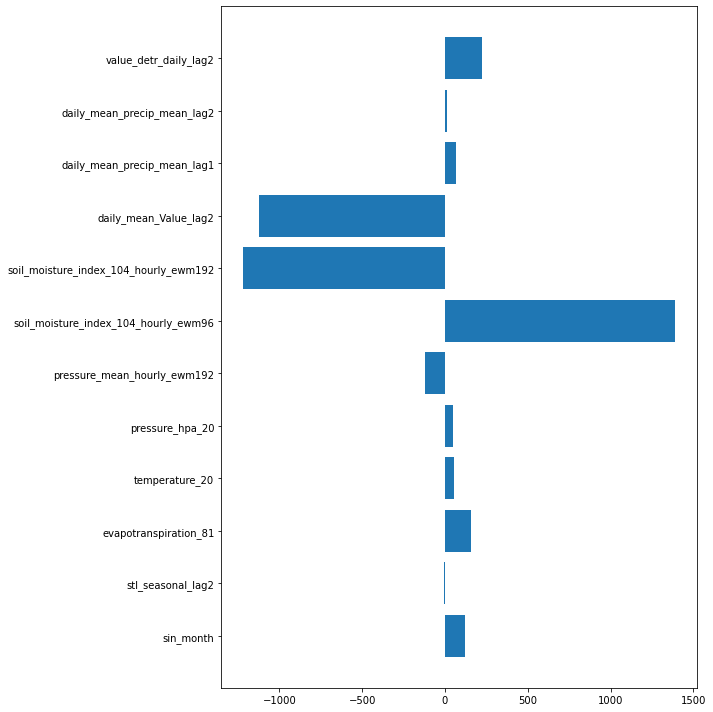

In [26]:
lm = final.named_steps['regressor']
importance = lm.coef_
plt.figure(figsize=(10,10))
plt.barh([x for x in selected_vars], importance)
plt.tight_layout()
plt.savefig(plots_path / 'weights_walkforward.png')
plt.show()

Last days evaluation. Green dashed predicted trend, red prediction, blue actual


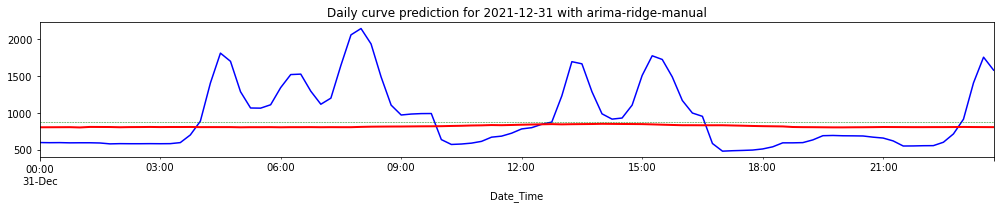

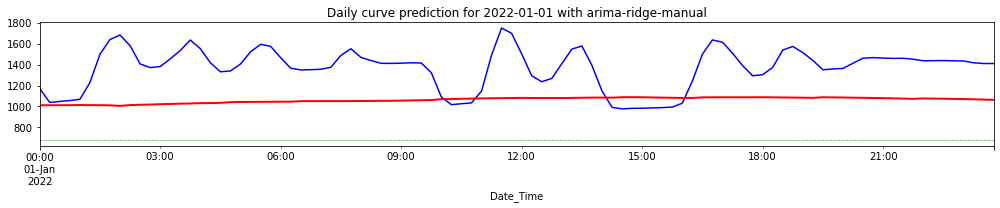

In [27]:
print("Last days evaluation. Green dashed predicted trend, red prediction, blue actual")
tsplot(y_true['2021-12-31'], y_pred=y_pred['2021-12-31'], y_detr=features['2021-12-31'][detrender],
       label=f'Daily curve prediction for 2021-12-31 with arima-ridge-manual', do_plot_acf=False,
       filepath=plots_path / 'last_day_31.png'
       )

tsplot(y_true['2022-01-01'], y_pred=y_pred['2022-01-01'], y_detr=features['2022-01-01'][detrender],
       label=f'Daily curve prediction for 2022-01-01 with arima-ridge-manual', do_plot_acf=False,
       filepath=plots_path / 'last_day_1.png'
       )

In [28]:
'''
Output prediction
'''
X = X_all[selected_vars]
y = X_all[target_new]
sample_weights = get_sample_weights(X_all, 0.05)

final.fit(X, y, regressor__sample_weight=sample_weights)

X_test = features_new['2022-01-02':'2022-01-03'][selected_vars]
trend_test = features_new['2022-01-02':'2022-01-03'][detrender]
y_pred_test = pd.DataFrame(final.predict(X_test), index=X_test.index, columns=[target_new])
value_pred = trend_test + y_pred_test[target_new]

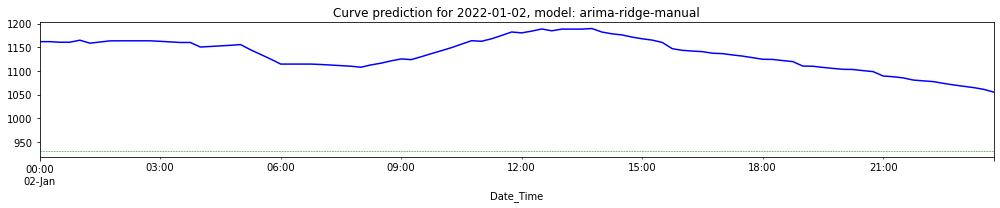

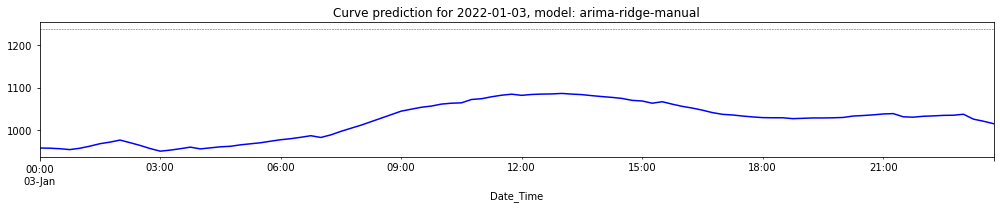

In [29]:
tsplot(value_pred['2022-01-02'], y_detr=trend_test['2022-01-02'], do_plot_acf=False,
       label="Curve prediction for 2022-01-02, model: arima-ridge-manual",
       filepath=plots_path / 'pred_02.png'
       )

tsplot(value_pred['2022-01-03'], y_detr=trend_test['2022-01-03'], do_plot_acf=False,
       label='Curve prediction for 2022-01-03, model: arima-ridge-manual',
       filepath=plots_path / 'pred_03.png'
       )

In [30]:
value_pred = pd.DataFrame(value_pred, columns=['Value'])
value_pred.to_csv(product['data'])